# Linear bayesian


In [1]:
"""
Fill in the missing code. The lines with missing code have the string "#####" or '*'
"INSTRUCTIONS" comments explain how to fill in the mising code.
the outputfile.txt has the printouts from the program.
Your results should be similar within reason, if not, re-run the program,
since we are using RandomizedSearchCV, meaning there is some randomness involved.
Actually, we added np.random.seed() to fix the results, so you can check them.

You will be filling in code in two types of models:
1. a regression model and
2. a classification model.

Most of the time, because of similarities,
you can cut and paste from one model to the other.
But in a few instances, you cannot do this, so
you need to pay attention.
Also, in some cases,
you will find a "hint" for a solution 
in one of the two scripts (regression or classification)
that you can use as inspiration for the other.

This double task gives you the opportunity to look at the results
in both regression and classification approaches.

At the bottom, you will find some questions that we pose.
You do not need to write and turn in the answer to these questions,
but we strongly recommend you find out the answers to them.

"""
"""
In this homework you will substitute the svc in linear_svc_optim_talib.py with
a Mixed Naive Bayesian classifier (for categorical and continuous predictors).
This model is compatible with Scikit-learn models, pipelines etc.
You need to install it with: 
pip install mixed-naive-bayes
https://archive.is/Ki1DS
"""
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import ta
from ta.trend import EMAIndicator 


np.random.seed(1) #to fix the results
rs=2

In [2]:
#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy()


#buld the best window features after the exploratory data analysis:
for n in list(range(1,15)):
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
    

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

#df = np.log(df+1)

"""
"""
#transform the target
#you have the option of a 3 label target or a 2 label target

#2 label target
#df['retFut1_categ']=0
#df.loc[df['retFut1']>df['retFut1'][:10000].quantile(q=0.51),'retFut1_categ']=1

#3 label target gets better results
df['retFut1_categ']=0
df.loc[df['retFut1']>df['retFut1'][:10000].quantile(q=0.66),'retFut1_categ']=1
df.loc[df['retFut1']<df['retFut1'][:10000].quantile(q=0.34),'retFut1_categ']=-1



#always check to see that the labels occur in equal numbers
dfgroups = df.groupby("retFut1_categ").count() #if they do not, use "balanced" parameter in the estimator(see below)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#Build some Ta-lib features, with n=10, to be optiized in the pipeline
n=10
# df['RSI']=ta.RSI(np.array(df['<CLOSE>']), timeperiod=n)
df['RSI']= ta.momentum.RSIIndicator(close=df['<CLOSE>'], window=n).rsi()

df['SMA'] = df['<CLOSE>'].rolling(window=n).mean()
df['Corr']= df['<CLOSE>'].rolling(window=n).corr(df['SMA'])

# df['SAR']=ta.SAR(np.array(df['<HIGH>']),np.array(df['<LOW>']), 0.2,0.2)
df['SAR']=ta.trend.PSARIndicator(high=df['<HIGH>'], 
                                    low=df['<LOW>'],
                                    close=df['<CLOSE>'],
                                    step=0.2, 
                                    max_step=0.2).psar()

# df['ADX']=ta.ADX(np.array(df['<HIGH>']),np.array(df['<LOW>']), np.array(df['<OPEN>']), timeperiod =n)
df['ADX']=ta.trend.ADXIndicator(high=df['<HIGH>'], 
                                low=df['<LOW>'], 
                                close=df['<CLOSE>'], 
                                window=n).adx()


df['OO']= df['<OPEN>']-df['<OPEN>'].shift(1)
df['OC']= df['<OPEN>']-df['<CLOSE>']
df.fillna(0, inplace=True)

#select the features (by dropping)
cols_to_drop = ["<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]

In [3]:
"""
INSTRUCTIONS:
this MixedNB model expects that the categories (within a categorical featues) not skip levels:
1, 2, 3 etc. are allowed but not 2, 3, 6 etc.
So it is a good idea to use LabelEncoder on all categorical features and on the target
to make sure that no levels are skipped

"""
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# x_train.hour = #####
# x_test.hour = #####
# x_train.day = #####
# x_test.day = #####
# y_train.retFut1_categ = #####
# y_test.retFut1_categ = #####

x_train.hour = le.fit_transform(x_train.hour)
x_test.hour = le.transform(x_test.hour)
x_train.day = le.fit_transform(x_train.day)
x_test.day = le.transform(x_test.day)
y_train.retFut1_categ = le.fit_transform(y_train.retFut1_categ)
y_test.retFut1_categ = le.transform(y_test.retFut1_categ)

In [4]:
#set up the grid search and fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import matthews_corrcoef
from sklearn.svm import LinearSVC
import detrendPrice 
import WhiteRealityCheckFor1 
from mixed_naive_bayes import MixedNB

In [5]:
def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    #print(phi_k_corr)
    print(phi_k_p_val)
    return phi_k_corr

#ph_k is supposed to be better than phi, provided here for comparison
def phi(y_true, y_pred):
    mcc = matthews_corrcoef(y_true,y_pred) #a.k.a. phi
    print (mcc)
    return mcc

#for optimizing the timeperiod of RSI and ADX
#x is a dataframe because this happens first in the pipeline
#def RSI_ADX_optimizer(x, timeperiod=None):
#    x['RSI'] =ta.RSI(np.array(x['<CLOSE>']), timeperiod=timeperiod)
#    x['ADX'] = ta.ADX(np.array(x['<HIGH>']),np.array(x['<LOW>']), np.array(x['<OPEN>']), timeperiod=timeperiod)
#    return x
def RSI_ADX_optimizer(x, timeperiod=10):
    # x[4] =ta.RSI(x[3], timeperiod=timeperiod) 
    # x[5] = ta.ADX(x[1],x[2], x[0], timeperiod=timeperiod)
    # x[0]x[1]x[2]x[3]x[4]x[5] are '<OPEN>','<HIGH>','<LOW>','<CLOSE>','RSI', 'ADX' 

    # modified; use df instead of numpy arrays
    x = x.copy()  # don't modify original

    x['RSI'] = ta.momentum.RSIIndicator(close=x['<CLOSE>'], window=timeperiod).rsi()
    x['ADX'] = ta.trend.ADXIndicator(
        high=x['<HIGH>'],
        low=x['<LOW>'],
        close=x['<CLOSE>'],
        window=timeperiod
    ).adx()

    x['RSI'] = x['RSI'].fillna(0)
    x['ADX'] = x['ADX'].fillna(0)

    return x

#myscorer= "accuracy"  #same as None; 
#myscorer = make_scorer(phi_k, greater_is_better=True)
myscorer="f1_macro"
#my_scorer="f1_weighted" 
#myscorer = make_scorer(phi, greater_is_better=True) 

#when using smoother, use TimesSeriesSplit
#split = 5 
#split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window
split = TimeSeriesSplit(n_splits=5)

# rsiadx = FunctionTransformer(RSI_ADX_optimizer)
rsiadx = FunctionTransformer(RSI_ADX_optimizer, kw_args={'timeperiod': 10}, validate=False)


In [6]:
"""
INSTRUCTIONS:
Note that we eliminated the step converting categories to dummies
"""

# numeric_sub_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('scaler', StandardScaler())])
# categorical_sub_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0))])

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

numeric_features_no = []
for i in numeric_features_ix:
    numeric_features_no.append(x_train.columns.get_loc(i))
categorical_features_no = []
for i in categorical_features_ix:
    categorical_features_no.append(x_train.columns.get_loc(i))
    
col_no = []
for c in list(['<OPEN>','<HIGH>','<LOW>','<CLOSE>','RSI', 'ADX']):
    col_no.append(x_train.columns.get_loc(c))

#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('rsiadx', rsiadx, col_no),    
        ('num', numeric_sub_pipeline, numeric_features_no),
        ('cat', categorical_sub_pipeline, categorical_features_no)], remainder='passthrough')


<OPEN>     float64
<HIGH>     float64
<LOW>      float64
<CLOSE>    float64
ret1       float64
ret2       float64
ret3       float64
ret4       float64
ret5       float64
ret6       float64
ret7       float64
ret8       float64
ret9       float64
ret10      float64
ret11      float64
ret12      float64
ret13      float64
ret14      float64
hour         int64
day          int64
RSI        float64
SMA        float64
Corr       float64
SAR        float64
ADX        float64
OO         float64
OC         float64
dtype: object


In [7]:
pd.set_option('display.max_columns', None)
x_train.iloc[100]

<OPEN>      1.451700
<HIGH>      1.451700
<LOW>       1.448100
<CLOSE>     1.451700
ret1        0.001172
ret2        0.000620
ret3        0.000758
ret4        0.000896
ret5        0.000896
ret6        0.001518
ret7        0.002278
ret8        0.002763
ret9        0.002348
ret10       0.002071
ret11       0.001725
ret12       0.001172
ret13       0.001794
ret14       0.000482
hour        4.000000
day         2.000000
RSI        60.785083
SMA         1.449840
Corr       -0.375575
SAR         0.000000
ADX        21.189181
OO          0.001700
OC          0.000000
Name: 2000-01-19 12:00:00, dtype: float64

In [8]:
"""
INSTRUCTIONS:
    
MixedNB needs to know the column index of the categorical features.
To find out this info:
change RSI_ADX_optimizer(x, timeperiod=None) to timeperiod=10
Run the Pipeline's fit_transform method on x_train.values using only the preprocessor step
save the result in inspect_me and run lines from 1 upto and including the line with inspect_me
open inspect_me in the variable explorer and jot down the column index of the categorical columns
they will not be the same index as originally
put the column index information in the categorical_features parameter of MixedNB
change RSI_ADX_optimizer(x, timeperiod=None) to timeperiod=None (optional) and run the whole file
"""
#to get inspect_me: change (momentarily) RSI_ADX_optimizer(x, timeperiod=None) to timeperiod=10
inspect_me = preprocessor.fit_transform(x_train)
print(inspect_me.shape)
print(len(inspect_me[0]))  # to see the first row of the transformed data
inspect_me[100]

(10000, 33)
33


array([ 1.45170000e+00,  1.45170000e+00,  1.44810000e+00,  1.45170000e+00,
        6.10081499e+01,  1.75488053e+01, -2.00424107e-01, -2.15028152e-01,
       -2.14629117e-01, -1.96727774e-01,  7.36880698e-01,  2.86568364e-01,
        2.90023089e-01,  3.01357667e-01,  2.74697069e-01,  4.17168040e-01,
        5.74252472e-01,  6.51982791e-01,  5.30136485e-01,  4.52254631e-01,
        3.68844823e-01,  2.52576749e-01,  3.60743563e-01,  1.17985005e-01,
        7.50392011e-01, -1.86107612e-01, -1.45835905e+00, -1.00005000e-02,
       -8.85264288e-01,  7.47022292e-01, -1.82669684e-02,  4.00000000e+00,
        2.00000000e+00])

> cat cols: day and hour, which are the last two in the inspect_me array

In [9]:
mnb = MixedNB(categorical_features=[31,32]) #by insepection of inspect_me the new categorcal columns are * and **
#mnb.fit(w,y_train.values.ravel())

pipe = Pipeline(steps=[('preprocessor', preprocessor),('mnb', mnb)])

timeperiod_rs = [{'timeperiod': 5},{'timeperiod': 10},{'timeperiod': 15}]

param_grid = {'preprocessor__rsiadx__kw_args':  timeperiod_rs}

grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True, random_state=2)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_mnb.csv")


Best parameters : {'preprocessor__rsiadx__kw_args': {'timeperiod': 15}}
Best cross-validation score : 21.61


In-sample: CAGR=0.00290405 Sharpe ratio=0.126352 maxDD=-0.116802 maxDDD=5287 Calmar ratio=0.0248629



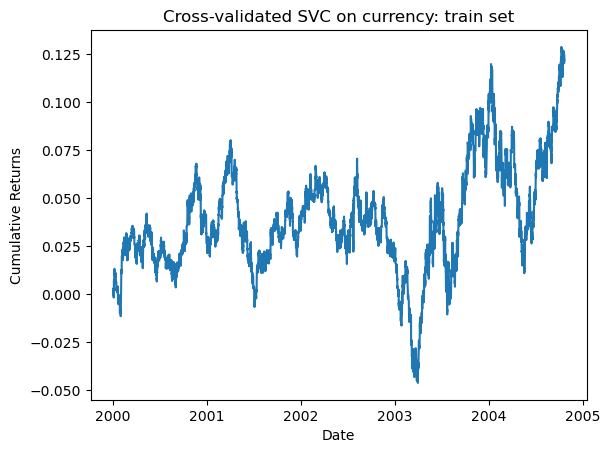

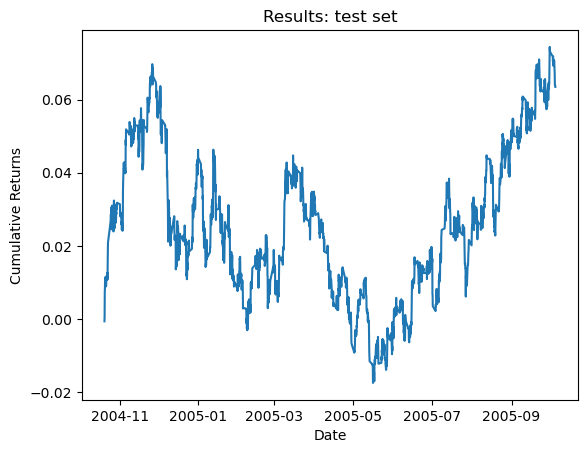

In [12]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS


dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated SVC on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Results: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

In [ ]:
#metrics
accscore = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})

dfc.head()


,y_true,y_pred
0,2,0
1,0,0
2,0,0
3,0,0
4,0,0


In [17]:
dfc.phik_matrix(interval_cols=[])

,y_true
y_true,1.0


In [19]:
dfc.phik_matrix(interval_cols=[]).iloc[0,0]

1.0

Out-of-sample: CAGR=0.00778146 Sharpe ratio=0.254854 maxDD=-0.0814735 maxDDD=1709 Calmar ratio=0.0955092  phi_k_corr=1.0 phi_k_p_val=0.0  accscore=0.3985

Ljung-Box test p-value 3.486729520371116e-05


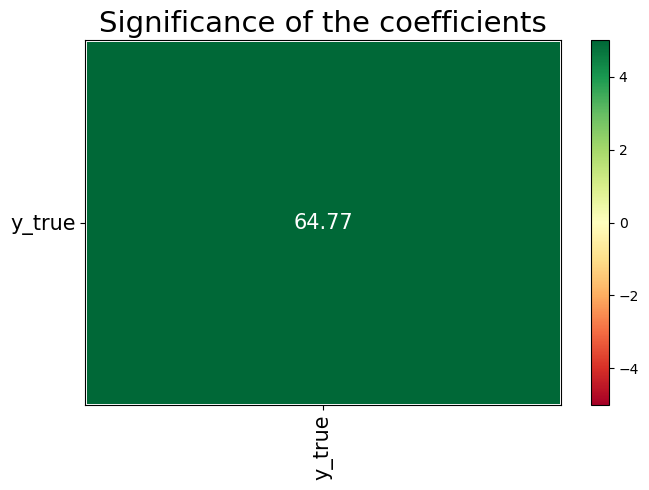

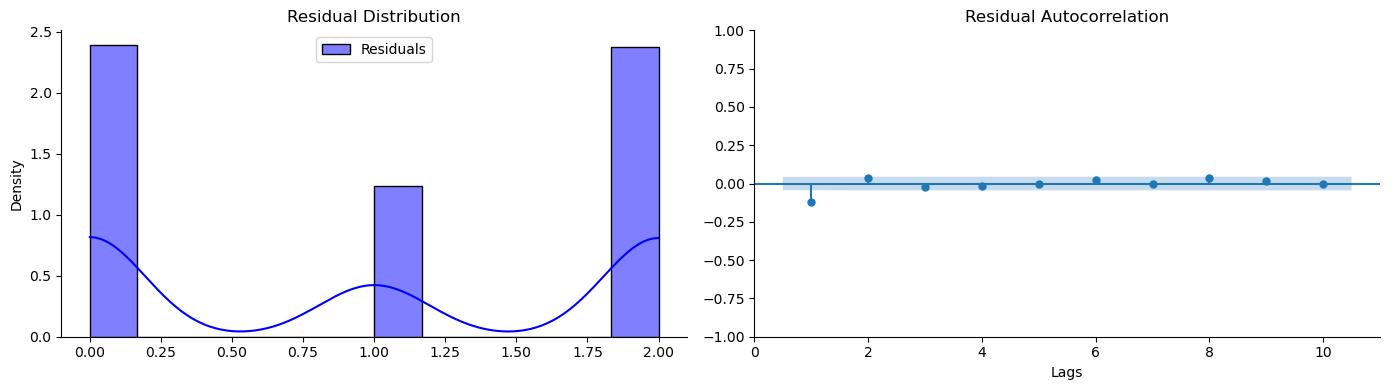

In [23]:
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[0,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[0,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accscore={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accscore))


#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
sns.histplot(residuals, kde=True, stat="density", ax=axes[0], label='Residuals', color='blue')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
# plt.close("all")

#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

average return -0.003686
[-0.00322236  0.00292134]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.9844


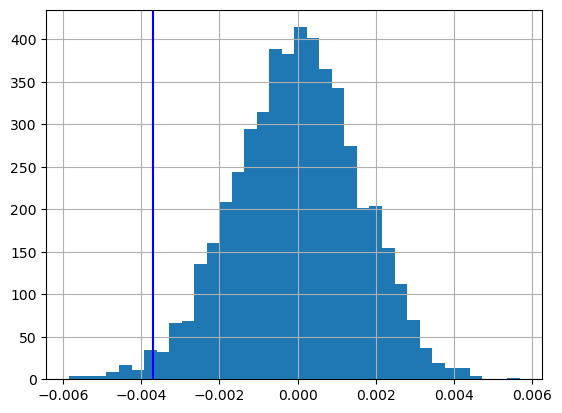

In [24]:
#white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()

